# Topic similarity

The aim of this notebook is to test a strategy to measure similarity between an **expert profile** and **project description**. 

Measuring similarity is suposed to be useful in determining how expert profiles fit for a given project description.

The poposed alternatives to test similarity include:

* LDA (topic modelling)
* word2vec

This notebook is organized as follows:

* First, we load the data set
* Second, we determine the languages of the author's articles to filter the majority language class.
* Finally, we train a LDA model and implement a similarity function to evaluate a test case for finding authors with similar content to the content in the text case.

### Load the data

In [1]:
import logging

from os import listdir

import pandas as pd

import spacy

from spacy_langdetect import LanguageDetector

from time import process_time

from multiprocessing import Pool

%matplotlib inline

In [2]:
logging.basicConfig(filename='../logs/console.log', 
                    level=logging.INFO,
                    filemode='a', 
                    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')

In [3]:
filenames = [x for x in listdir('../data/sedici') if 'node_articles_ciencias_informaticas' in x]

In [5]:
df = pd.DataFrame()

for filename in filenames:
    df = pd.concat([df, pd.read_csv('../data/sedici/{0}'.format(filename))], ignore_index=True, sort=False)

In [6]:
df.shape

(65334, 5)

In [7]:
df.head()

,author_id,article_id,title,abstract,language
0,55286,24446,Análisis automático del rendimiento de ejecuci...,La programación paralela más tradicional oblig...,NaN
1,55286,9582,Development and tuning framework of master/wor...,Parallel/distributed programming is a complex ...,NaN
2,55286,20899,Método de Reducción de Incertidumbre basado en...,La problemática existente a raíz de la falta d...,NaN
3,55286,9524,Process tracking for dynamic tuning applicatio...,The computational resources need by the scient...,NaN
4,55286,23166,Mapas de riesgo de incendios forestales basado...,La valoración del riesgo en los incendios fore...,NaN


Since we will be training models for a single language. Next step is to determine what are the proportion of languages usage in their content. 

## Language usage

In [9]:
nlp = spacy.load("es_core_news_sm")

In [10]:
nlp.add_pipe(LanguageDetector(), name="language_detector", last=True)


Now, let's get the language by analysing the abstract of each article

In [12]:
logger = logging.getLogger('Language processing')

def get_languages(tuples):
    '''
    Get languages for every row in tuples
    
    -----
    param 
    tuples tuple with (index, row) from pandas.iterrows()
    '''
    
    idx, row = tuples
    
    languages = []
    
    #if index in scale:
    #    logger.info('Determining languages from article number {0}'.format(index))
    #index = index + 1
        
    tic = process_time()
    
    doc = nlp(str(row['abstract']))
    languages.append(doc._.language['language'])
    
    toc = process_time()
    
    logger.info("determininig language for article {0} took {1}ms.".format(idx, toc-tic))
    
    return languages

In [13]:
article_lang = []

with Pool(4) as p:
    article_lang = p.map(get_languages, df.iterrows())

In [14]:
len(article_lang)

65334

In [15]:
df['language'] = [''.join(x) for x in article_lang]

In [ ]:
df.to_csv('../data/sedici/node_articles_ciencias_informaticas_with_language.csv', index=False)

### Load data from CSV

In [16]:
df = pd.read_csv('../data/sedici/node_articles_ciencias_informaticas_with_language.csv')

In [17]:
df['language'].value_counts()

es    27812
en     4325
pt      168
tl       99
it        8
ca        6
af        4
de        2
so        1
Name: language, dtype: int64

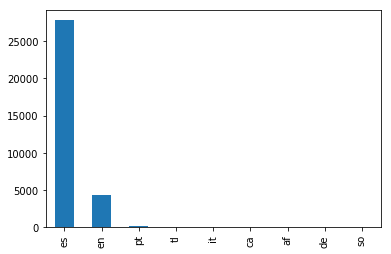

In [18]:
df['language'].value_counts().plot(kind='bar')

We will be working with spanish documents, since 'es' is the majority language class.

In [19]:
df[df['language'] == 'es'].shape

(27812, 5)

In [20]:
data = df[df['language'] == 'es']
data = data[['author_id', 'article_id', 'title', 'abstract']]

In [21]:
data.head()

,author_id,article_id,title,abstract
0,55286,24446,Análisis automático del rendimiento de ejecuci...,La programación paralela más tradicional oblig...
2,55286,20899,Método de Reducción de Incertidumbre basado en...,La problemática existente a raíz de la falta d...
4,55286,23166,Mapas de riesgo de incendios forestales basado...,La valoración del riesgo en los incendios fore...
5,55286,23181,Algoritmos genéticos guiados para predicción d...,En este trabajo se propone una metodología par...
8,55286,21622,Modelización y evaluación de performance en pa...,Se exponen las ideas principales de una línea ...


Let's get a single field 'content' by appending titles and abstracts, for each author.

In [22]:
concat_results = []

author_ids = data['author_id'].unique()

for author_id in author_ids:
    
    content = ''
    
    for idx, row in data[data['author_id'] == author_id].iterrows():
        content = content + '. '.join([str(row['title']), str(row['abstract'])]) + '\n' 
        
    concat_results.append((author_id, content))
    
df_content = pd.DataFrame(concat_results, columns=['author_id', 'content'])    

In [23]:
df_content.head()

,author_id,content
0,55286,Análisis automático del rendimiento de ejecuci...
1,63510,Adaptabilidad en familia de aplicaciones web. ...
2,54180,Uso de VRPN en la implementación de una BCI p...
3,58677,m-Experiencia de articulación universidad-escu...
4,64654,Determinación del espesor de aleaciones metáli...


In [24]:
len(df_content)

3225

In [25]:
print(df_content.iloc[0]['content'])

Análisis automático del rendimiento de ejecución de programas paralelos. La programación paralela más tradicional obliga al programador, después de haber diseñado la aplicación, a analizar el rendimiento de la aplicación que se acaba de diseñar. El programador debe analizar una enorme cantidad de información obtenida de la ejecución de un programa. En este artículo, se propone una herramienta de análisis automático que permite a los programadores evitar esa tarea difícil. La herramienta se centra en la búsqueda de intervalos de ineficiencia a lo largo del tiempo de ejecución de la aplicación. Los problemas de rendimiento son analizados en detalle, en busca de posibles causas de la ineficiencia y sus soluciones.
Método de Reducción de Incertidumbre basado en HPC. La problemática existente a raíz de la falta de exactitud que se encuentra en los parámetros de entrada en cualquier modelo científi co o físico, puede producir graves consecuencias en la salida del mismo si éste se trata de al

Now, we have a data set where each row contains the author id as well as their associated content of scientific productions (titles and abstracts).

## LDA

In [26]:
# import dependencies
%matplotlib inline
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
import gensim
from gensim.models import LdaModel
from gensim import models, corpora, similarities
import re
from nltk.stem.porter import PorterStemmer
import time
from nltk import FreqDist
from scipy.stats import entropy
import matplotlib.pyplot as plt

Our first approach involves applying LDA to build expert profiles using topic models.

Here, **expert profiles** are defined as a set topic models, and this models are trained using documents asociated to every expert. For instance, in academics this documents could be research papers where the expert is an author.

**Project descriptions** are defined as the contributions to the topic models of the expert profiles.

The similarity between the project descriptions and the expert profiles can be measured using the Jensen-Shannon Distance (see [ref](https://www.kaggle.com/ktattan/lda-and-document-similarity#Similarity-Queries-and-Unseen-Data))

LDA should work better with large datasets, however **content** have only titles and abstracts.

Let's get an idea of what is the length of the content column.

In [27]:
content_size = []
with Pool(4) as p:
    content_size = p.map(len, df_content['content'])

In [28]:
df_content['length'] = content_size

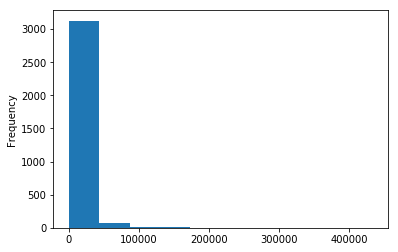

In [29]:
df_content['length'].plot(kind='hist')

In [30]:
df_content.dtypes

author_id     int64
content      object
length        int64
dtype: object

In [31]:
df_content['length'].describe()

count      3225.000000
mean       9357.815194
std       18409.464828
min         123.000000
25%        2320.000000
50%        4440.000000
75%        9067.000000
max      434430.000000
Name: length, dtype: float64

The strategy is to train topic models based on the **whole content** of data set.

### Start LDA processing

In [32]:
# Cleaning processes from https://www.kaggle.com/ktattan/lda-and-document-similarity#Similarity-Queries-and-Unseen-Data

def initial_clean(text):
    """
    Function to clean text of websites, email addresess and any punctuation
    We also lower case the text
    """
    text = re.sub("((\S+)?(http(s)?)(\S+))|((\S+)?(www)(\S+))|((\S+)?(\@)(\S+)?)", " ", text)
    text = re.sub("[^a-zA-ZñÑáéíóúÁÉÍÓÚü ]", "", text)
    text = text.lower() # lower case the text
    text = nltk.word_tokenize(text)
    return text

stop_words = stopwords.words('spanish')
def remove_stop_words(text):
    """
    Function that removes all stopwords from text
    """
    return [word for word in text if word not in stop_words]

stemmer = PorterStemmer()
def stem_words(text):
    """
    Function to stem words, so plural and singular are treated the same
    """
    try:
        text = [stemmer.stem(word) for word in text]
        text = [word for word in text if len(word) > 1] # make sure we have no 1 letter words
    except IndexError: # the word "oed" broke this, so needed try except
        pass
    return text

def apply_all(text):
    """
    This function applies all the functions above into one
    """
    return stem_words(remove_stop_words(initial_clean(text)))

### Get word frequency

In [33]:
df_content['tokenized'] = df_content['content'].apply(apply_all)

In [34]:
# first get a list of all words
all_words = [word for item in list(df_content['tokenized']) for word in item]
# use nltk fdist to get a frequency distribution of all words
fdist = FreqDist(all_words)
len(fdist) # number of unique words

63183

In [35]:
all_words[:10]

['análisi',
 'automático',
 'rendimiento',
 'ejecución',
 'programa',
 'paralelo',
 'programación',
 'paralela',
 'tradicion',
 'obliga']

In [36]:
# choose k and visually inspect the bottom 10 words of the top k
k = 15000
top_k_words = fdist.most_common(k)
top_k_words[-10:]

[('cubana', 7),
 ('programático', 7),
 ('eliminado', 7),
 ('mastozoología', 7),
 ('period', 7),
 ('refracción', 7),
 ('eslabon', 7),
 ('competenciasla', 7),
 ('expandirs', 7),
 ('natación', 7)]

In [37]:
# define a function only to keep words in the top k words
top_k_words,_ = zip(*fdist.most_common(k))
top_k_words = set(top_k_words)
def keep_top_k_words(text):
    return [word for word in text if word in top_k_words]

In [38]:
df_content['tokenized'] = df_content['tokenized'].apply(keep_top_k_words)

Train LDA

In [39]:
def train_lda(data):
    """
    This function trains the lda model
    We setup parameters like number of topics, the chunksize to use in Hoffman method
    We also do 2 passes of the data since this is a small dataset, so we want the distributions to stabilize
    """
    num_topics = 100
    chunksize = 300
    dictionary = corpora.Dictionary(data['tokenized'])
    corpus = [dictionary.doc2bow(doc) for doc in data['tokenized']]
    t1 = time.time()
    # low alpha means each document is only represented by a small number of topics, and vice versa
    # low eta means each topic is only represented by a small number of words, and vice versa
    lda = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary,
                   alpha=1e-2, eta=0.5e-2, chunksize=chunksize, minimum_probability=0.0, passes=2)
    t2 = time.time()
    print("Time to train LDA model on ", len(df), "articles: ", (t2-t1)/60, "min")
    return dictionary,corpus,lda

In [40]:
dictionary,corpus,lda = train_lda(df_content)

Time to train LDA model on  32425 articles:  1.301446008682251 min


In [41]:
# show_topics method shows the the top num_words contributing to num_topics number of random topics
lda.show_topics(num_topics=10, num_words=20)

[(64,
  '0.051*"investigación" + 0.031*"web" + 0.028*"proyecto" + 0.028*"universidad" + 0.023*"inteligencia" + 0.021*"nacion" + 0.018*"desarrollo" + 0.018*"línea" + 0.018*"ambient" + 0.016*"inteligent" + 0.016*"agent" + 0.015*"artifici" + 0.015*"trabajo" + 0.015*"objetivo" + 0.012*"patagonia" + 0.012*"computación" + 0.011*"planificación" + 0.010*"gener" + 0.010*"incentivar" + 0.010*"marco"'),
 (36,
  '0.023*"tráfico" + 0.020*"cloud" + 0.019*"rede" + 0.015*"seguridad" + 0.013*"servicio" + 0.012*"comput" + 0.011*"internet" + 0.011*"red" + 0.008*"modelo" + 0.008*"nuevo" + 0.008*"infraestructura" + 0.008*"dato" + 0.007*"recurso" + 0.007*"análisi" + 0.007*"tecnología" + 0.006*"trabajo" + 0.006*"aplicacion" + 0.006*"distribución" + 0.006*"wireless" + 0.006*"gran"'),
 (11,
  '0.054*"reconocimiento" + 0.019*"patron" + 0.018*"sistema" + 0.017*"video" + 0.016*"visión" + 0.016*"segmentación" + 0.013*"objeto" + 0.013*"método" + 0.011*"descriptor" + 0.009*"resultado" + 0.009*"cámara" + 0.009*"traba

### Similarity queries

Determine similarity with test document

In [42]:
file = open('../data/sedici/test.txt', 'r')

test_data = file.readline() # just one line



In [43]:
test_data

'Clasificación automática de contenedores de demandas y habilidades en selección de expertos. La selección de expertos a menudo carece de descripciones útiles sobre las habilidades que los candidatos deben poseer para alcanzar las demandas requeridas para cubrir una posición dentro de una organización. Esta falta de descripciones inhibe la producción de evaluaciones precisas sobre la adecuación o congruencia entre demandas y habilidades (Adecuación Persona-Trabajo). Nosotros sostenemos que la clasificación automática de descripciones a partir de contextos de evaluación pueden contribuir a un mejor entendimiento de cómo los procesos de selección de expertos realmente trabajan. En este artículo, proponemos un enfoque de aprendizaje supervisado para la clasificación de descripciones que contengan demandas y habilidades a partir de transcripciones de tipo entrevista de trabajo. Asimismo, presentamos un caso de estudio de nominaciones de candidatos a ocupar posiciones ejecutivas en el servi

In [45]:
new_bow = dictionary.doc2bow(apply_all(test_data))

In [46]:
new_doc_distribution = np.array([tup[1] for tup in lda.get_document_topics(bow=new_bow)])

Get topic distributions

In [47]:
doc_topic_dist = np.array([[tup[1] for tup in lst] for lst in lda[corpus]])

Define a similarity function

In [48]:
def jensen_shannon(query, matrix):
    """
    This function implements a Jensen-Shannon similarity
    between the input query (an LDA topic distribution for a document)
    and the entire corpus of topic distributions.
    It returns an array of length M where M is the number of documents in the corpus
    """
    # lets keep with the p,q notation above
    p = query[None,:].T # take transpose
    q = matrix.T # transpose matrix
    m = 0.5*(p + q)
    return np.sqrt(0.5*(entropy(p,m) + entropy(q,m)))

Get most similar author's content

In [49]:
def get_most_similar_documents(query,matrix,k=10):
    """
    This function implements the Jensen-Shannon distance above
    and retruns the top k indices of the smallest jensen shannon distances
    """
    sims = jensen_shannon(query,matrix) # list of jensen shannon distances
    return sims.argsort()[:k] # the top k positional index of the smallest Jensen Shannon distances

In [50]:
# this is surprisingly fast
most_sim_ids = get_most_similar_documents(new_doc_distribution,doc_topic_dist)

In [51]:
most_similar_df = df_content[df_content.index.isin(most_sim_ids)]
most_similar_df['content']

38      Reuso orientado a dominios: hacia un enfoque b...
690     Identificación automática de usuarios conflict...
745     Construcción colaborativa de ontologías CO-Pro...
829     Técnicas y herramientas para desarrollo de sit...
1070    Hacia la obtención de un modelo de base de dat...
2599    Extendiendo la meta-arquitectura aportada por ...
2924    Desarrollo de un esquema de Gestión de Riesgos...
2972    Identificación automática de usuarios conflict...
3102    Diseño y evaluación tempranos para priorizar l...
3170    Diseño y evaluación tempranos para priorizar l...
Name: content, dtype: object

Get authors from file and print authors with content similar to the test data

In [52]:
authors = pd.read_csv('../data/sedici/authors.csv', names=['author_id', 'last_name', 'first_name', 'other'])

In [53]:
authors.shape

(22380, 4)

In [54]:
result = []

for idx, item in authors['author_id'].iteritems():
    result.append(item in most_similar_df['author_id'].tolist())

In [55]:
authors.iloc[result]

,author_id,last_name,first_name,other
1129,55260,Armentano,Marcelo G.,NaN
1499,56975,Baldo,Guillermo,NaN
2141,65150,Berdun,Franco,NaN
3855,54201,Caro,Angélica,NaN
8207,53345,Gaetán,Gabriela,NaN
12082,65486,Lugani,Carlos Fabián,NaN
12919,66892,Martín,Adriana Elba,NaN
13049,66892,Martín,Adriana Elba,NaN
13828,53349,Miranda,Gabriela,NaN
18059,55275,Roqué Fourcade,Luis,NaN


We can take a look at the articles of the authors retrieved by the similarity funcion.

In [59]:
df[df['author_id'] == 55260]

,author_id,article_id,title,abstract,language
6937,55260,70804,Identificación automática de usuarios conflict...,"Actualmente, las redes sociales cumplen un pap...",es
6938,55260,56972,Inferencia de roles de equipo a partir de cond...,"En un entorno de trabajo colaborativo, grupos ...",es
6939,55260,52117,Clasificación de conductas colaborativas a par...,"En un entorno de trabajo colaborativo, grupos ...",es
6940,55260,21462,El proyecto AGUSINA,Las vías rápidas de información se nos present...,es
6941,55260,41726,Inducción de preferencias a partir del context...,Los sistemas de recomendación que usan técnica...,es
6942,55260,65939,Detección de conductas a partir de interaccion...,La observación y el análisis de la dinámica de...,es


## Conclusions

In this notebook we test a strategy to measure similarity between documents and expert profiles. 
This approach introduce an alternative for expert finding, where queries are represented by text documents, and expert profiles are represented by LDA models.
Results of the similarity function must be validated somehow. This validation could be made by introducing
feedback from experts from personel selection domain.